Tell the model to ONLY use GPU

In [1]:
import os
os.environ['CUDA_DEVICE_ORDER'] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

Import libraries

In [2]:
import tensorflow as tf
from keras import Model, regularizers
from keras.applications.xception import Xception, preprocess_input
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Flatten, Dropout, UpSampling2D, GlobalAveragePooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D,Dropout, DepthwiseConv2D
import itertools
from keras.utils import plot_model
from keras.utils.image_utils import img_to_array, array_to_img, img_to_array, load_img
from keras.optimizers import Adam, SGD
from keras import models, Sequential
import keras.backend as K
from keras.callbacks import CSVLogger, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.models import load_model
import matplotlib.pyplot as plt
import random
import cv2
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import Image, HTML
import seaborn as sn
from collections import Counter

Limit the GPU growth to only what's needed

In [3]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    #Invalid device or can't modify virtual devices once installed
    print("Failed to limit the GPU Memory")

Gather Data

In [4]:
IMG_HEIGHT=224 
IMG_WIDTH = 224
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)

IMAGE_SHAPE = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))

batch_size=32

PATIENCE =10

epochs = 50

csv_logger = CSVLogger('log.csv', separator=',', append=True)

ADAM_LEARNING_RATE = 0.0001

classes=['Angry','Contemp', 'Disgust','Fear','Happy','Neutral','Sad','Surprise']

train_data_dir = r'../../DATASETS/AffectNet/train/'
validation_data_dir = r'../../DATASETS/AffectNet/test/'

In [5]:
# Data augmentation

train_generator = ImageDataGenerator(rescale = 1./255,
                                   featurewise_center=False,
                                   featurewise_std_normalization=False,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   fill_mode='nearest',
                                   horizontal_flip=True)

validation_generator  = ImageDataGenerator(rescale = 1./255)

In [6]:
# Load datasat

train_dataset  = train_generator.flow_from_directory(directory = train_data_dir,
                                                   target_size = IMG_SIZE,
                                                   class_mode = 'categorical',
                                                   color_mode='grayscale',
                                                   batch_size = batch_size,
                                                   shuffle=True)

test_dataset = validation_generator.flow_from_directory(directory = validation_data_dir,
                                                  target_size = IMG_SIZE,
                                                  class_mode = 'categorical',
                                                  color_mode='grayscale',
                                                  shuffle =True,
                                                  batch_size = batch_size)

Found 24799 images belonging to 8 classes.
Found 6192 images belonging to 8 classes.


In [7]:
# Total train/test sample

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_data_dir, 'train')
test_count = count_exp(validation_data_dir, 'test')

HTML(train_count.append(test_count).to_html(escape=False))

# HTML(train_count.append(test_count).to_html(escape=False))

C:\Users\darks\AppData\Local\Temp\ipykernel_39216\2138799908.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  HTML(train_count.append(test_count).to_html(escape=False))


,anger,contempt,disgust,fear,happy,neutral,sad,surprise
train,2910,2543,2128,2897,4036,4105,2744,3436
test,721,635,532,724,1009,1026,686,859


In [8]:
# Data labels

class_labels = test_dataset.class_indices
class_labels

{'anger': 0,
 'contempt': 1,
 'disgust': 2,
 'fear': 3,
 'happy': 4,
 'neutral': 5,
 'sad': 6,
 'surprise': 7}

In [9]:
# See the shape of any data

train_sample=next(train_dataset)
print(train_sample[0].shape)

(32, 224, 224, 1)


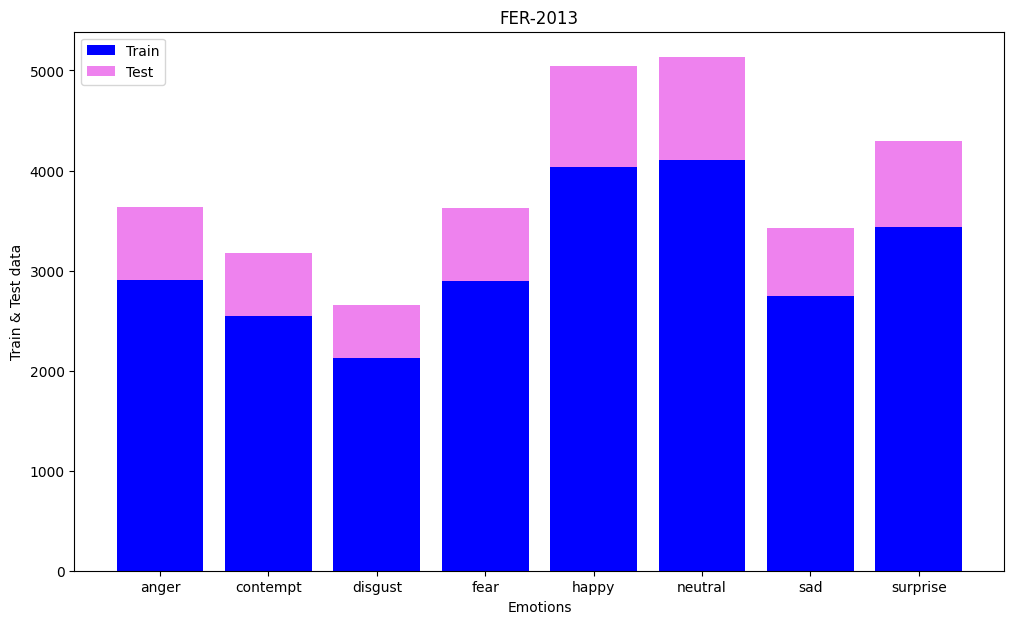

In [10]:
# # lot distribution of train/test dataste per class

x = list(test_count.columns)
y1 =train_count.iloc[0].to_list()
y2 = test_count.iloc[0].to_list()
plt.figure(figsize=(12,7))

plt.bar(x, y1, color='blue')
plt.bar(x, y2, bottom=y1, color='violet')
plt.xlabel("Emotions")
plt.ylabel("Train & Test data")
plt.legend(["Train", "Test"], loc='upper left')
plt.title("FER-2013")
plt.savefig('distribution.png')
plt.show()

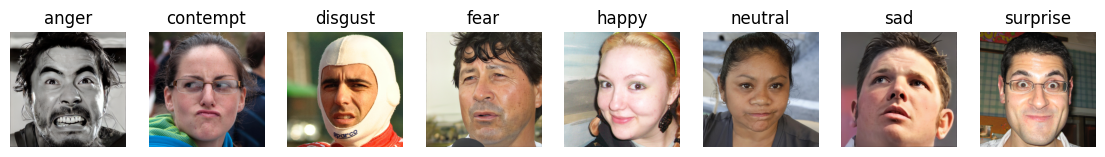

In [11]:
# Plot image of each class

plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_data_dir):
    img = load_img((train_data_dir + expression +'/'+ os.listdir(train_data_dir + expression)[1]))
    plt.subplot(1,8,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

Build the Model

Load pre-trained model and add extra dense layer for classification

In [12]:
base_model = Xception(include_top=False, weights='imagenet')

base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                        

In [13]:
# Freezing Layers all layers

for layer in base_model.layers:
    layer.trainable=False

In [14]:
print("Model trainable",len(base_model.layers))

Model trainable 132


In [15]:
# Model trainable

print("Model trainable",len(base_model.trainable_variables))

Model trainable 0


In [16]:
# Build transfer learning Model

input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))

conv = Conv2D(3, kernel_size=(3, 3), padding='same')(input)

model = base_model(conv)

model = GlobalAveragePooling2D()(model)

model = Flatten()(model)
model = Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001))(model)
model = BatchNormalization()(model)
model = Dropout(0.3)(model)

model = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001))(model)
model = BatchNormalization()(model)
model = Dropout(0.3)(model)

pred = Dense(8, activation="softmax")(model)

model = Model(inputs = input, outputs = pred)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 3)       30        
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                             

Compile and Fit Model

In [17]:
# Compile model

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

adam = Adam(learning_rate= ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy',metrics=METRICS)

In [18]:
# Run Model

counter = Counter(train_dataset.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : round(max_val/num_images,2) for class_id, num_images in counter.items()}  

lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = PATIENCE,verbose = 1,factor = 0.50, min_lr = 1e-10)
mcp = ModelCheckpoint('model.h5')
es = EarlyStopping(verbose=1, patience=20)

In [19]:
history = model.fit(train_dataset, validation_data = test_dataset, epochs = epochs, callbacks=[lrd,mcp,es,csv_logger], class_weight = class_weights)

Epoch 1/50
775/775 [==============================] - 297s 364ms/step - loss: 3.6123 - accuracy: 0.8598 - precision: 0.3559 - recall: 0.1502 - auc: 0.6787 - f1_score: 0.2096 - val_loss: 2.2876 - val_accuracy: 0.8823 - val_precision: 0.5762 - val_recall: 0.2198 - val_auc: 0.7882 - val_f1_score: 0.3147 - lr: 1.0000e-04
Epoch 2/50
775/775 [==============================] - 268s 346ms/step - loss: 3.1968 - accuracy: 0.8711 - precision: 0.4619 - recall: 0.1887 - auc: 0.7448 - f1_score: 0.2662 - val_loss: 2.1468 - val_accuracy: 0.8864 - val_precision: 0.6343 - val_recall: 0.2162 - val_auc: 0.8172 - val_f1_score: 0.3191 - lr: 1.0000e-04
Epoch 3/50
775/775 [==============================] - 264s 340ms/step - loss: 3.0445 - accuracy: 0.8757 - precision: 0.5067 - recall: 0.1969 - auc: 0.7640 - f1_score: 0.2814 - val_loss: 2.0924 - val_accuracy: 0.8895 - val_precision: 0.6693 - val_recall: 0.2292 - val_auc: 0.8263 - val_f1_score: 0.3388 - lr: 1.0000e-04
Epoch 4/50
775/775 [=======================

In [20]:
save_model = model.save('Xception_tf_224_grayscale.h5')

In [ ]:
#Test the model
model = load_model('Model_Transfer/MOdel_transfer_96/MobileNetV2_tf.h5', compile=False)

In [21]:
#  Som Scores of train & test set

train_evalation = model.evaluate(train_dataset)
test_evaluation = model.evaluate(test_dataset)

194/194 [==============================] - 46s 239ms/step - loss: 1.4260 - accuracy: 0.8984 - precision: 0.6937 - recall: 0.3346 - auc: 0.8782 - f1_score: 0.4484


In [22]:
metric_list = ["Loss","Accuracy", "Precision", "Recall", "Auc", "F1_Score"]

df = pd.DataFrame(list(zip(metric_list, 
                           [round(num, 3) for num in train_evalation], 
                           [round(num, 3) for num in test_evaluation])),
                  columns=['Metric Name', 'Train', 'Validate'])

print('\n\nModel Scores\n')

HTML(df.to_html(escape=False))



Model Scores



,Metric Name,Train,Validate
0,Loss,1.314,1.426
1,Accuracy,0.906,0.898
2,Precision,0.762,0.694
3,Recall,0.356,0.335
4,Auc,0.901,0.878
5,F1_Score,0.482,0.448


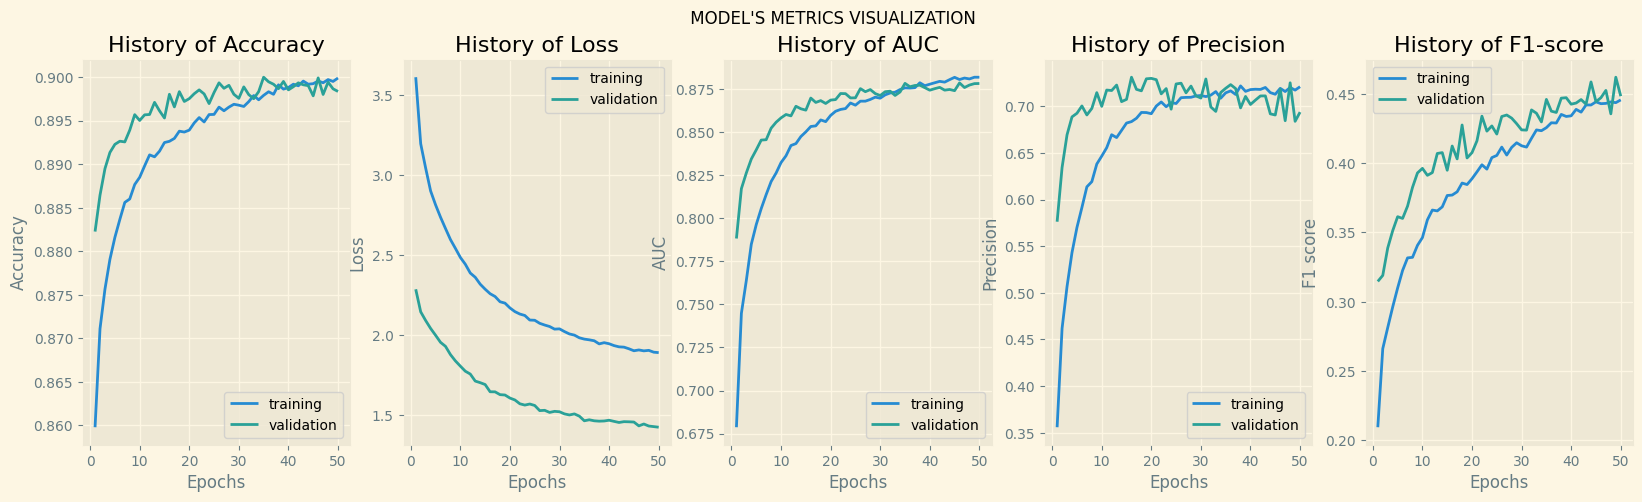

In [23]:
hs=history.history

acc = hs['accuracy']
val_acc = hs['val_accuracy']
loss =  hs['loss']
val_loss = hs['val_loss']
auc =  hs['auc']
val_auc = hs['val_auc']
precision =hs['precision']
val_precision =hs['val_precision']
f1 = hs['f1_score']
val_f1 = hs['val_f1_score']              

plt.style.use('Solarize_Light2')

fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

ax1.plot(range(1, len(acc) + 1), acc)
ax1.plot(range(1, len(val_acc) + 1), val_acc)
ax1.set_title('History of Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(['training', 'validation'])


ax2.plot(range(1, len(loss) + 1), loss)
ax2.plot(range(1, len(val_loss) + 1), val_loss)
ax2.set_title('History of Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(['training', 'validation'])

ax3.plot(range(1, len(auc) + 1), auc)
ax3.plot(range(1, len(val_auc) + 1), val_auc)
ax3.set_title('History of AUC')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('AUC')
ax3.legend(['training', 'validation'])

ax4.plot(range(1, len(precision) + 1), precision)
ax4.plot(range(1, len(val_precision) + 1), val_precision)
ax4.set_title('History of Precision')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Precision')
ax4.legend(['training', 'validation'])

ax5.plot(range(1, len(f1) + 1), f1)
ax5.plot(range(1, len(val_f1) + 1), val_f1)
ax5.set_title('History of F1-score')
ax5.set_xlabel('Epochs')
ax5.set_ylabel('F1 score')
ax5.legend(['training', 'validation'])

plt.show()

Confusion Matrix

In [24]:
y_true = test_dataset.classes
y_pred =  model.predict(test_dataset)
y_pred= tf.argmax(y_pred, axis = 1).numpy()

cm = confusion_matrix(y_true = y_true, y_pred = y_pred)

194/194 [==============================] - 45s 228ms/step


Confusion matrix, without normalization

[[ 66  95  92  65 106 146  72  79]
 [ 63  88  71  62 107 129  50  65]
 [ 51  69  75  56  76  95  49  61]
 [ 68  94 102  66 113 125  66  90]
 [ 99 131 106 118 146 209  80 120]
 [ 97 123 132 103 157 211  89 114]
 [ 81  80  85  82  94 135  63  66]
 [ 91 103 110  82 121 188  74  90]]





C:\Users\darks\AppData\Local\Temp\ipykernel_39216\3719412231.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


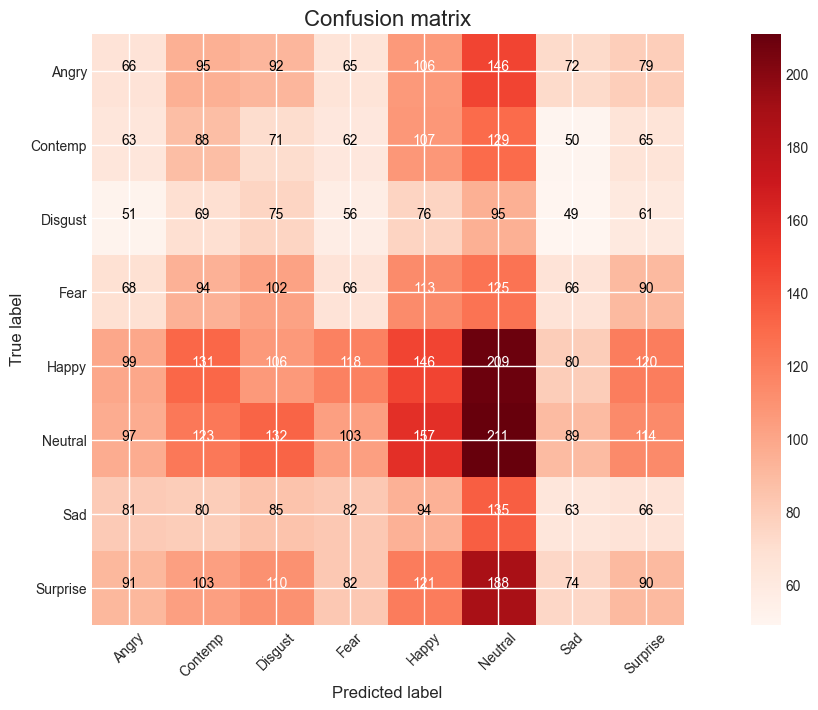

In [25]:
plt.rcParams['figure.figsize'] = (14,7)

plt.style.use('seaborn-darkgrid')
plt.imshow(cm, interpolation='nearest', cmap='Reds')
plt.title('Confusion matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)    

print('Confusion matrix, without normalization\n')   
print(cm)

print("\n\n")
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

C:\Users\darks\AppData\Local\Temp\ipykernel_39216\3749358223.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


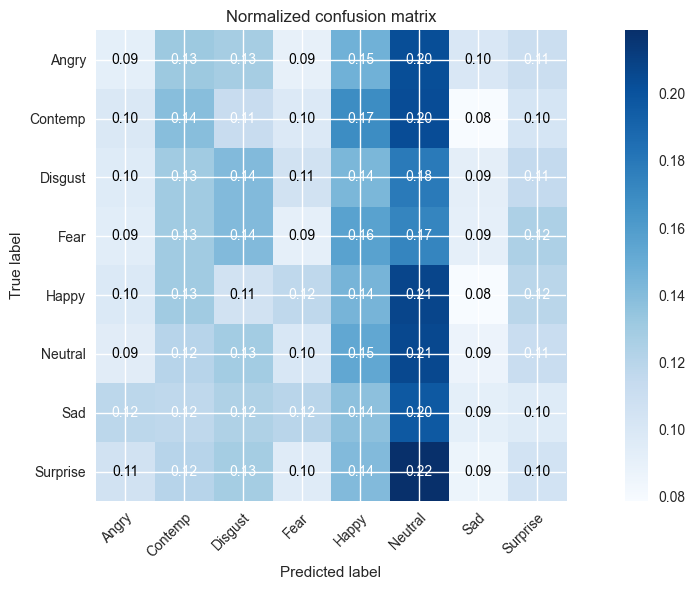

In [26]:
plt.style.use('seaborn')

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(12,6))

im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title = 'Normalized confusion matrix',
       ylabel='True label',
       xlabel='Predicted label')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


fmt = '.2f' 
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()

Save Model

In [51]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
plt.style.use('grayscale')
plt.grid(visible=None)
img_path='../input/fer2013/test/sad/PrivateTest_10702106.jpg'
test_image=image.load_img(img_path,target_size= IMAGE_SIZE,color_mode='grayscale')
test_image=image.img_to_array(test_image)
print(test_image.shape)
plt.imshow(test_image)
plt.show()

Test

In [ ]:
img=image.load_img(img_path,target_size=IMAGE_SIZE)
img = np.expand_dims(img, axis=0)
print(img.shape)

In [ ]:
result=model.predict(img)
print(result[0])
y_pred=np.argmax(result[0])
print('The person facial emotion is:',classes[y_pred])